In [1]:
import pandas as pd

df = pd.read_csv("sample_questions.csv")

In [2]:
df_dct = df.to_dict(orient="records")

In [3]:
from sentence_transformers import SentenceTransformer
from qdrant_client import QdrantClient
from qdrant_client.models import Distance, VectorParams, PointStruct
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from typing import Any
import uuid


class QdrantConnector:
      
    def __init__(
        self, 
        qdrant_host: str = "localhost", 
        qdrant_port: int = 6333,
        embedding_model: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        collection_name: str = "pdf_documents"
    ):
        self.qdrant_client = QdrantClient(host=qdrant_host, port=qdrant_port)
        self.embedding_model = SentenceTransformer(embedding_model)
        self.collection_name = collection_name

    def _get_sentence_splitter(self, chunk_size: int, overlap: int) -> RecursiveCharacterTextSplitter:
        return RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,     # Number of characters per chunk
            chunk_overlap=overlap,   # Overlap to maintain context
            separators=["\n\n", "\n", ".", " ", ""]  # Prioritize splitting on paragraph, newline, and sentence boundaries
        )
    
    def recreate_collection(self):
        """Check and create collection in Qdrant if it doesn't exist"""
        try:
            collections = self.qdrant_client.get_collections()
            collection_names = [col.name for col in collections.collections]
            if self.collection_name in collection_names:
                print(f"Collection '{self.collection_name}' already exists, deleting it for fresh start.")
                self.qdrant_client.delete_collection(collection_name=self.collection_name)
            vector_size = self.embedding_model.get_sentence_embedding_dimension()
            
            self.qdrant_client.create_collection(
                collection_name=self.collection_name,
                vectors_config=VectorParams(
                    size=vector_size,
                    distance=Distance.COSINE
                )
            )
            print(f"Created collection '{self.collection_name}'")
        except Exception as e:
            print(f"Error creating collection: {e}")

    def upload_to_qdrant(
        self, 
        text: str,
        metadata: dict[str, Any] = None
    ) -> None:
        """
        Upload chunks and embeddings to Qdrant
        
        Args:
            chunks: List of text chunks
            embeddings: Embeddings for chunks
            metadata: Additional metadata (e.g., filename, page)
        
        Returns:
            List of IDs of added points
        """
        sentence_chunks = self._get_sentence_splitter(metadata["chunk_size"], metadata["overlap"]).split_text(text)
        print(f"text spliited into {len(sentence_chunks)} chunks")
        for i, chunk in enumerate(sentence_chunks):
            point_id = str(uuid.uuid4())
            embedding = self.embedding_model.encode(chunk)

            payload = {
                "text": chunk,
                "chunk_index": i,
                "chunk_length": len(chunk)
            }
            if metadata:
                payload.update(metadata)

            point = PointStruct(
                id=point_id,
                vector=embedding.tolist(),
                payload=payload
            )
            try:
                self.qdrant_client.upsert(
                    collection_name=self.collection_name,
                    points=[point]
                )
                print(f"Uploaded point {point_id} to Qdrant")
            except Exception as e:
                print(f"Error uploading to Qdrant: {e}")
                return None

    def search_similar(self, query: str, limit: int = 5) -> list[dict]:
            """
            Search for similar chunks to query
            
            Args:
                query: Text query
                limit: Maximum number of results
            
            Returns:
                List of similar chunks with metadata
            """
            # Create embedding for query
            query_embedding = self.embedding_model.encode([query])[0]
            
            # Search in Qdrant
            search_results = self.qdrant_client.search(
                collection_name=self.collection_name,
                query_vector=query_embedding.tolist(),
                limit=limit
            )
            
            results = []
            for result in search_results:
                results.append({
                    "text": result.payload["text"],
                    "score": result.score,
                    "file_name": result.payload.get("file_name", "unknown"),
                    "chunk_index": result.payload.get("chunk_index", 0)
                })
            
            return results

/Users/tmatuszewski/Projects/pdf-research-assistant/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def build_prompt(query, search_results):
    prompt_template = """
        nothink/
        You're a pdf research assistant. Answer the QUESTION based on the CONTEXT from the Qdrant database.
        Use only the facts from the CONTEXT when answering the QUESTION.

        QUESTION: {question}

        CONTEXT: {context}
    """.strip()

    prompt = prompt_template.format(question=query, context=search_results).strip()
    return prompt

In [5]:
qdrant_connector = QdrantConnector(
    embedding_model = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    collection_name = "pdf_documents"
)

In [6]:
import ollama
from ollama import GenerateResponse

def rag(query: str, model: str) -> GenerateResponse:
    print("Searching in qdrant db")
    search_result = qdrant_connector.search_similar(query=query)
    ollama_host = "http://localhost:11434"
    client = ollama.Client(host=ollama_host)
    prompt = build_prompt(query, search_result)
    print(prompt)
    response = client.generate(
        model=model,
        prompt=prompt
        
    )
    return response


In [7]:
asnwers = []

In [8]:
for question in df_dct:
    model = "qwen3:latest"
    query = question["question"]
    response = rag(query, model)
    answer = response.response.replace("<think>\n", "").replace("</think>\n", "")
    print(answer)
    asnwers.append(
        {
            "question": query,
            "answer": answer,
            "model": model
        }
    )

Searching in qdrant db


/var/folders/k2/8_xbq0kj3yq1ydl1c3mcpp580000gn/T/ipykernel_51225/2977155495.py:110: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = self.qdrant_client.search(


nothink/
        You're a pdf research assistant. Answer the QUESTION based on the CONTEXT from the Qdrant database.
        Use only the facts from the CONTEXT when answering the QUESTION.

        QUESTION: Jaka jest nazwa kierunku studiów opisanych w programie?

        CONTEXT: [{'text': '8. Dokumentacja programu studiów jest opiniowana przez Senacką Komisję ds. Kształcenia. \n9. Ostatecznie program studiów, w drodze odpowiedniej uchwały, ustala Senat Akademicki Politechniki \nPoznańskiej, a rektor wydaje zarządzenie w sprawie utworzenia kierunku studiów. \nMonitorowanie oraz zapewnienie odpowiednich standardów jakości kształcenia na kierunku  \nzarządzanie i inżynieria produkcji  bazuje na nadzorze realizacji programu studiów, opracowywaniu \npropozycji zmian mających na celu doskonalenie procesu kształcenia oraz programu studiów, \ngwarantowaniu wysokiej jakości kształcenia, odpowiednim i spójnym skorelowaniu treści programowych \nmiędzy prowadzonymi przedmiotami, a także zapewni

KeyboardInterrupt: 

In [12]:
prompt2_template = """
/nothink/
You are an expert evaluator for a RAG system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [28]:
relevance = []

In [29]:
for i, element in enumerate(asnwers):
    question = element["question"]
    answer_llm = element["answer"]
    model = element["model"]
    prompt2 = prompt2_template.format(question=question, answer_llm=answer_llm)
    response = ollama.generate(
        model=model,
        prompt=prompt2
    )
    print(f"Evaluating question: {question}, index: {i}, model: {model}")
    relevance.append(response)

Evaluating question: Jaka jest nazwa kierunku studiów opisanych w programie?, index: 0, model: qwen3:1.7b
Evaluating question: Na jakim poziomie Polskiej Ramy Kwalifikacji znajduje się ten kierunek?, index: 1, model: qwen3:1.7b
Evaluating question: Ile semestrów trwają studia stacjonarne na kierunku zarządzanie i inżynieria produkcji?, index: 2, model: qwen3:1.7b
Evaluating question: Jaki tytuł zawodowy otrzymuje absolwent tego kierunku?, index: 3, model: qwen3:1.7b
Evaluating question: Ile punktów ECTS trzeba zdobyć, aby ukończyć studia stacjonarne?, index: 4, model: qwen3:1.7b
Evaluating question: Ile godzin zajęć obejmuje program studiów stacjonarnych?, index: 5, model: qwen3:1.7b
Evaluating question: Ile godzin praktyk przewidziano w programie dla studiów stacjonarnych?, index: 6, model: qwen3:1.7b
Evaluating question: W jakim języku prowadzone są zajęcia?, index: 7, model: qwen3:1.7b
Evaluating question: Jakie są kluczowe efekty uczenia się w zakresie wiedzy?, index: 8, model: qwe

In [41]:
relevance_list = []
import json
for i, response in enumerate(relevance):
    print(f"Relevance evaluation for response index {i}:")
    try:
        relevance_list.append(json.loads(response.response.replace("<think>\n\n","").replace("</think>\n\n","").replace("\n  ", "").strip()))
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON for response index {i}: {e}")
        print("Response content:")
        relevance_list.append({"Relevance": "NOT_RELEVANT", "Explanation": "Error decoding JSON"})

Relevance evaluation for response index 0:
Relevance evaluation for response index 1:
Relevance evaluation for response index 2:
Relevance evaluation for response index 3:
Relevance evaluation for response index 4:
Relevance evaluation for response index 5:
Relevance evaluation for response index 6:
Relevance evaluation for response index 7:
Error decoding JSON for response index 7: Invalid control character at: line 1 column 244 (char 243)
Response content:
Relevance evaluation for response index 8:
Relevance evaluation for response index 9:
Relevance evaluation for response index 10:
Relevance evaluation for response index 11:
Relevance evaluation for response index 12:
Relevance evaluation for response index 13:
Relevance evaluation for response index 14:
Relevance evaluation for response index 15:
Relevance evaluation for response index 16:
Relevance evaluation for response index 17:
Relevance evaluation for response index 18:
Relevance evaluation for response index 19:
Relevance e

In [42]:
asnwers

[{'question': 'Jaka jest nazwa kierunku studiów opisanych w programie?',
  'answer': '\n\nNazwa kierunku studiów opisanych w programie to **zarządzanie i inżynieria produkcji**.',
  'model': 'qwen3:1.7b'},
 {'question': 'Na jakim poziomie Polskiej Ramy Kwalifikacji znajduje się ten kierunek?',
  'answer': '\nKierunek zarządzanie i inżynieria produkcji znajduje się w **szóstym poziomie Polskiej Ramy Kwalifikacji**.',
  'model': 'qwen3:1.7b'},
 {'question': 'Ile semestrów trwają studia stacjonarne na kierunku zarządzanie i inżynieria produkcji?',
  'answer': '\nStudia stacjonarne na kierunku zarządzanie i inżynieria produkcji trwają **7 semestrów**.',
  'model': 'qwen3:1.7b'},
 {'question': 'Jaki tytuł zawodowy otrzymuje absolwent tego kierunku?',
  'answer': '\n\nAbsolwent kierunku zarządzanie i inżynieria produkcji otrzymuje tytuł zawodowy **"inżynier"**.',
  'model': 'qwen3:1.7b'},
 {'question': 'Ile punktów ECTS trzeba zdobyć, aby ukończyć studia stacjonarne?',
  'answer': '\nAby uko

In [43]:
result = [{**elem, **asnwers[relevance_list.index(elem)]} for elem in relevance_list]

In [44]:
relevance_list

[{'Relevance': 'RELEVANT',
  'Explanation': "The generated answer directly addresses the question by stating the name of the study program's major, which is explicitly asked in the question. The answer is accurate and matches the content provided."},
 {'Relevance': 'RELEVANT',
  'Explanation': "The generated answer directly addresses the question by stating that the direction 'Zarządzanie i inżynieria produkcji' is located in the sixth level of the Polish Qualification Framework. The answer is precise and matches the question's intent."},
 {'Relevance': 'RELEVANT',
  'Explanation': 'The generated answer directly addresses the question by stating that studies in the field of management and production engineering last 7 semesters. It is relevant and accurate based on the information provided.'},
 {'Relevance': 'RELEVANT',
  'Explanation': "The generated answer directly addresses the question by stating that the graduate of the Management and Production Engineering program holds the profe

In [45]:
df = pd.DataFrame(result)
df.to_csv("rag_evaluation_results.csv", index=False)

<Axes: title={'center': 'RAG Evaluation Relevance Distribution'}, xlabel='Relevance'>

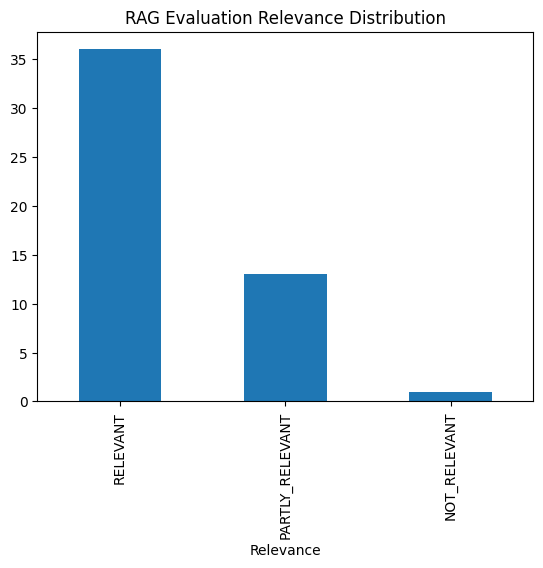

In [46]:
df["Relevance"].value_counts().plot(kind="bar", title="RAG Evaluation Relevance Distribution")